In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import iberoSignalPro.preprocesa as ib
from sklearn.preprocessing import StandardScaler
import os

In [2]:
import antropy as ant

In [3]:
from scipy.stats import kruskal
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

## Funciones

In [4]:
def obtener_win(sig, binary_sig, siPlot=True):
    # Ensure binary_sig is binary
    binary_sig = np.array(binary_sig).flatten()
    binary_sig = (binary_sig >= 0.5).astype(int)  # Convert to binary (0 or 1)

    diff = np.diff(binary_sig)
    idx_actividad = np.where(diff == 1)[0]
    idx_rep = np.where(diff == -1)[0]

    print(binary_sig.shape)

    if binary_sig[0] == 1:
        idx_actividad = np.insert(idx_actividad, 0, 0)
    #if binary_sig[-1] == 1:
    #    idx_actividad = np.append(idx_actividad, len(binary_sig) -1)
    
    if binary_sig[0] == 0:
        idx_rep = np.insert(idx_rep, 0, 0)
    #if binary_sig[-1] == 0:
    #    idx_rep = np.append(idx_rep, len(binary_sig) - 1)
    
    #print(idx_actividad)
    #print(idx_rep)
    
    # Ensure idx_actividad and idx_rep have the same length by adding samples
    while len(idx_actividad) < len(idx_rep):
        idx_actividad = np.append(idx_actividad, idx_actividad[-1])
    while len(idx_rep) < len(idx_actividad):
        idx_rep = np.append(idx_rep, idx_rep[-1])
    
    if idx_rep[0] < idx_actividad[0]:
        ventanas_reposo = np.stack((idx_rep, idx_actividad)).T
        ventanas_actividad = np.stack((idx_actividad[:-1], idx_rep[1:])).T
    else:
        ventanas_reposo = np.stack((idx_rep[:-1], idx_actividad[1:])).T
        ventanas_actividad = np.stack((idx_actividad[:], idx_rep[:])).T

    #print(ventanas_reposo.shape)
    #print(ventanas_actividad.shape)

    if siPlot:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 2, 1) 
        for ventana in ventanas_actividad:
            plt.plot(sig[ventana[0]: ventana[1]])
        plt.title('Ventanas de actividad')

        plt.subplot(1, 2, 2)  
        for ventana in ventanas_reposo:
            plt.plot(sig[ventana[0]: ventana[1]])
        plt.title('Ventanas de reposo')

        plt.show()

    return ventanas_actividad, ventanas_reposo

In [5]:
def compute_kruskal_wallis_anova(df, group_column, value_column):
    """
    Computes the Kruskal-Wallis H-test for given groups in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - group_column: Column name in df that contains the group labels.
    - value_column: Column name in df that contains the values to compare across groups.

    Returns:
    - The test statistic and p-value from the Kruskal-Wallis H-test.
    """
    
    groups = df[group_column].unique()
    
    group_data = [df[df[group_column] == group][value_column] for group in groups]
    
    test_stat, p_value = kruskal(*group_data)
    
    return test_stat, p_value


def compute_one_way_anova(df, group_column, value_column):
    """
    Computes the one-way ANOVA test for given groups in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - group_column: Column name in df that contains the group labels.
    - value_column: Column name in df that contains the values to compare across groups.

    Returns:
    - The F statistic and p-value from the one-way ANOVA test.
    """
    
    groups = df[group_column].unique()
    
    group_data = [df[df[group_column] == group][value_column] for group in groups]
    
    F_stat, p_value = f_oneway(*group_data)
    
    return F_stat, p_value


def compute_two_way_anova(df, dependent_var, factor1, factor2):
    """
    Computes the two-way ANOVA for a given DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - dependent_var: The name of the dependent variable (continuous).
    - factor1: The name of the first factor (independent variable).
    - factor2: The name of the second factor (independent variable).

    Returns:
    - ANOVA table as a DataFrame.
    """
    # Construct the formula for the two-way ANOVA
    formula = f'{dependent_var} ~ C({factor1}) + C({factor2}) + C({factor1}):C({factor2})'
    
    # Fit the model
    model = ols(formula, data=df).fit()
    
    # Perform ANOVA and return the table
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

In [6]:
def compute_t_test(df, group_column, value_column):
    """
    Computes the t-test for the means of two independent groups in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - group_column: Column name in df that contains the group labels.
    - value_column: Column name in df that contains the values to compare.
    - group1_label: The label of the first group for comparison.
    - group2_label: The label of the second group for comparison.

    Returns:
    - The T statistic and p-value from the t-test.
    """
    groups = df[group_column].unique()
    if(groups.shape[0] != 2):
        raise ValueError("Los gurpos deben de ser unicamente dos")
    # Extract data for the two specified groups
    group1_data = df[df[group_column] == groups[0]][value_column]
    group2_data = df[df[group_column] == groups[1]][value_column]
    
    # Perform the t-test
    T_stat, p_value = ttest_ind(group1_data, group2_data)
    
    return T_stat, p_value



def compute_paired_t_test(df, group_column, value_column):
    """
    Computes the paired t-test for the means of two related groups in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - group_column: Column name in df that contains the group labels.
    - value_column: Column name in df that contains the values to compare.

    Returns:
    - The T statistic and p-value from the paired t-test.
    """
    groups = df[group_column].unique()
    if len(groups) != 2:
        raise ValueError("Los gurpos deben de ser unicamente dos")
    
    # Extract data for the two specified groups
    group1_data = df[df[group_column] == groups[0]][value_column]
    group2_data = df[df[group_column] == groups[1]][value_column]
    
    # Ensure both groups have the same number of observations
    if len(group1_data) != len(group2_data):
        raise ValueError("Both groups must have the same number of observations for a paired t-test.")
    
    # Perform the paired t-test
    T_stat, p_value = ttest_rel(group1_data, group2_data)
    
    return T_stat, p_value

## Prueba particular

In [7]:
sujeto = "PabloRoca"
sesion = "S3"

df_10 = pd.read_csv(f"C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/{sujeto}/{sesion}/10deTorquePre.csv")
df_5 = pd.read_csv(f"C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/{sujeto}/{sesion}/5deTorquePre.csv")
df_0 = pd.read_csv(f"C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/{sujeto}/{sesion}/pasivoPre.csv")

fs = 10


In [8]:
df_10["label"] = df_10["Binaria"].apply(lambda x: '10' if x > 0.5 else 'Reposo')
df_5["label"] = df_5["Binaria"].apply(lambda x: '5' if x > 0.5 else 'Reposo')
df_0["label"] = df_0["Binaria"].apply(lambda x: '0' if x > 0.5 else 'Reposo')

In [9]:
mu_names = ["mu_" + ch for ch in ['CP4', 'C4', 'CP3', 'P3', 'C1', 'Pz', 'C3', 'P4', 'FC4', 'Oz', 'Cz']]
beta_names = ["beta_" + ch for ch in ['FCz', 'P4', 'Cz', 'CP4', 'CP3', 'C4', 'FC4']]
gamma_names = ["gamma_" + ch for ch in ['FC3', 'FC4', 'FCz', 'C1', 'C3', 'CP3']]

In [10]:
from sklearn.preprocessing import StandardScaler


In [11]:
columns_to_keep = mu_names + beta_names + gamma_names + ["label"]
df_10 = df_10[columns_to_keep]
df_5 = df_5[columns_to_keep]
df_0 = df_0[columns_to_keep]


In [12]:
# Filtrar los DataFrames para eliminar las filas donde label es "Reposo"
df_10 = df_10[df_10['label'] != "Reposo"]
df_5 = df_5[df_5['label'] != "Reposo"]
df_0 = df_0[df_0['label'] != "Reposo"]


In [13]:
#columns_to_normalize = mu_names + beta_names + gamma_names
#scaler = StandardScaler()

# Normalizar cada DataFrame
#df_10[columns_to_normalize] = scaler.fit_transform(df_10[columns_to_normalize])
#df_5[columns_to_normalize] = scaler.fit_transform(df_5[columns_to_normalize])
#df_0[columns_to_normalize] = scaler.fit_transform(df_0[columns_to_normalize])


In [14]:
big_df = pd.concat([df_10, df_5, df_0], ignore_index=True)
big_df = big_df.dropna()

In [15]:
p_values = []
significant_columns = []
thresh = 0.01
columns = big_df.columns
print(columns)
for column in columns:
    if column != 'label':
        
        test, p_val = compute_kruskal_wallis_anova(big_df, "label",  column)
        #test, p_val = compute_one_way_anova(df_analisis, "label",  column)
        
        #test, p_val = compute_t_test(big_df, "label",  column)
        #test, p_val = compute_paired_t_test(df_analisis, "label",  column)
        
        if(p_val < thresh):
            #sns.violinplot(x='label', y=column, data=big_df, hue='label', fill=False)
            #plt.show()
            p_values.append(p_val)
            significant_columns.append(column)
            print(f"Column: {column}, p-value: {p_val}")
        else:
            p_values.append(np.nan)


Index(['mu_CP4', 'mu_C4', 'mu_CP3', 'mu_P3', 'mu_C1', 'mu_Pz', 'mu_C3',
       'mu_P4', 'mu_FC4', 'mu_Oz', 'mu_Cz', 'beta_FCz', 'beta_P4', 'beta_Cz',
       'beta_CP4', 'beta_CP3', 'beta_C4', 'beta_FC4', 'gamma_FC3', 'gamma_FC4',
       'gamma_FCz', 'gamma_C1', 'gamma_C3', 'gamma_CP3', 'label'],
      dtype='object')
Column: mu_CP4, p-value: 9.349618663993607e-51
Column: mu_C4, p-value: 1.0217915411462077e-80
Column: mu_CP3, p-value: 4.917067246146477e-116
Column: mu_P3, p-value: 9.627219679126396e-122
Column: mu_C1, p-value: 0.0
Column: mu_Pz, p-value: 3.0043223412651687e-183
Column: mu_C3, p-value: 2.2664262591482735e-109
Column: mu_P4, p-value: 4.409918335478093e-101
Column: mu_FC4, p-value: 1.2296159847197172e-127
Column: mu_Oz, p-value: 7.615388232016401e-211
Column: mu_Cz, p-value: 0.0
Column: beta_FCz, p-value: 0.0
Column: beta_P4, p-value: 1.3573418938870235e-155
Column: beta_Cz, p-value: 0.0
Column: beta_CP4, p-value: 5.96571117705931e-235
Column: beta_CP3, p-value: 1.21097824

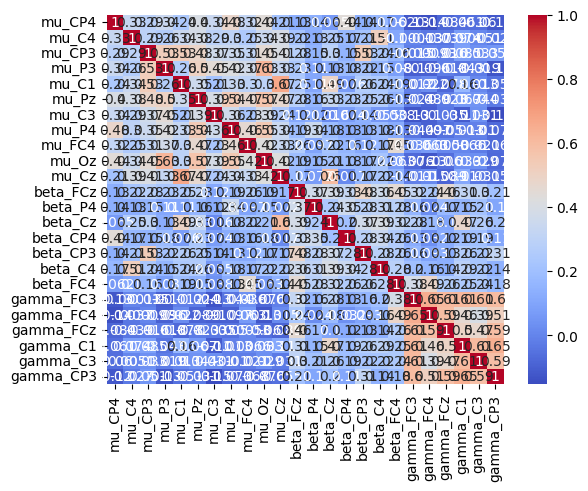

In [16]:
corr_mat = big_df.drop(columns="label")[significant_columns].corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')

abs_corr_matrix = corr_mat.abs()
corr_sum = abs_corr_matrix.sum()
least_correlated_columns = corr_sum.nsmallest(5).index
new_df = np.log10(big_df[least_correlated_columns])

In [17]:
new_df.head()

,beta_P4,beta_CP4,mu_C3,gamma_FC4,gamma_C3
0,-0.853272,-1.101749,-1.847439,-0.908390,-1.204268
1,-0.783451,-1.099984,-1.720934,-1.035677,-1.180234
2,-0.791475,-1.069816,-1.394264,-1.172926,-1.104730
3,-0.897323,-1.008648,-1.085482,-1.252361,-0.997019
4,-1.001969,-1.043776,-0.935641,-1.239187,-0.905067


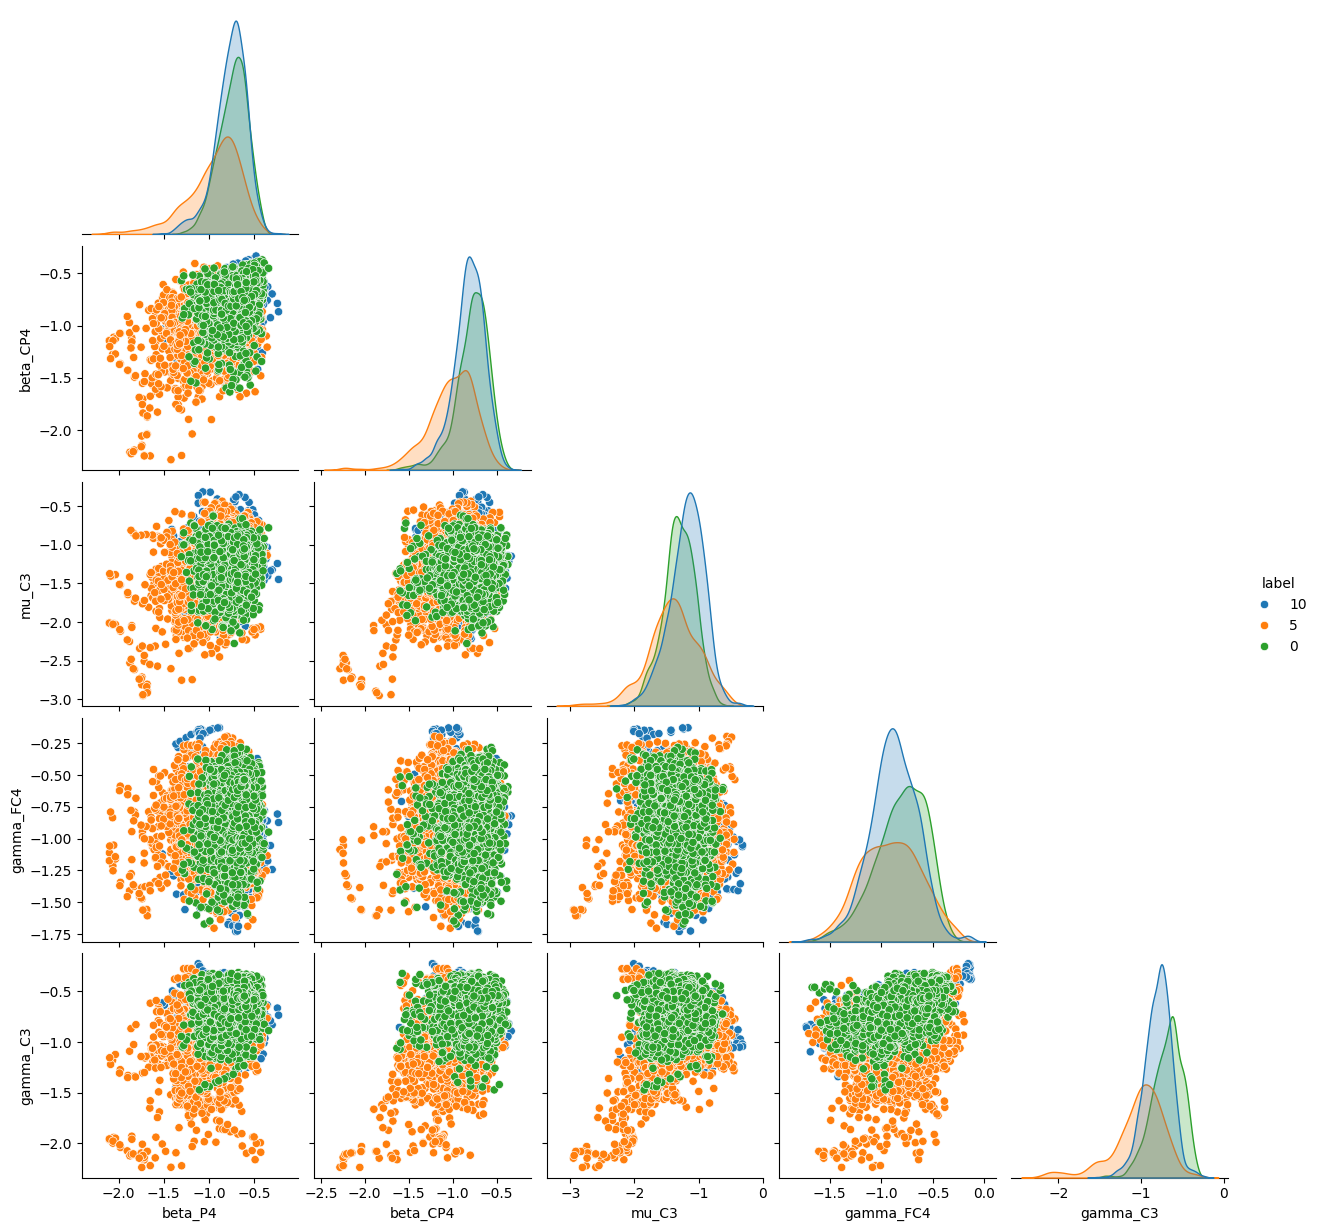

In [18]:
new_df["label"] = big_df["label"]
sns.pairplot(new_df, hue='label', diag_kind='kde', corner=True)

In [19]:
means = big_df.groupby('label').mean()

In [20]:
df_10means = np.nanmean(big_df[big_df["label"] == "10"].drop(columns="label").values, axis=0)
df_5means = np.nanmean(big_df[big_df["label"] == "5"].drop(columns="label").values, axis=0)
df_0means = np.nanmean(big_df[big_df["label"] == "0"].drop(columns="label").values, axis=0)

np.stack((df_10means, df_5means, df_0means)).shape


(3, 24)

In [21]:

def calculate_permutation_entropies(df, label_value, order=3, normalize=False):
    """
    Calcula la entropía de permutación para cada columna de un DataFrame filtrado por un valor de etiqueta específico.

    Parameters:
    df (DataFrame): El DataFrame de entrada.
    label_value (str): El valor de la etiqueta para filtrar el DataFrame.
    order (int): El orden de la entropía de permutación. Por defecto es 3.
    normalize (bool): Si se debe normalizar la entropía. Por defecto es False.

    Returns:
    np.array: Un array con las entropías calculadas para cada columna.
    """
    # Filtrar el DataFrame por el valor de la etiqueta
    filtered_df = df[df["label"] == label_value].drop(columns="label")
    
    # Calcular la entropía de permutación para cada columna
    entropies = np.array([ant.perm_entropy(filtered_df[col].values, order=order, normalize=normalize) for col in filtered_df.columns])
    
    return entropies

In [22]:
def moving_permutation_entropy(signal, window_size, step_size, order=3, normalize=False):
    """
    Calcula la entropía de permutación móvil de una señal.

    Parameters:
    signal (array-like): La señal de entrada.
    window_size (int): El tamaño de la ventana deslizante.
    step_size (int): El tamaño del paso de la ventana deslizante.
    order (int): El orden de la entropía de permutación. Por defecto es 3.
    normalize (bool): Si se debe normalizar la entropía. Por defecto es False.

    Returns:
    np.array: Un array con las entropías calculadas para cada ventana.
    """
    entropies = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        window = signal[start:start + window_size]
        entropy = ant.perm_entropy(window, order=order, normalize=normalize)
        entropies.append(entropy)
    return np.array(entropies)

In [23]:
def mean_permutation_entropy(df, carga="10", orden=5, t_ventan=100, step_size=1):
    """
    Calcula la entropía de permutación móvil promedio para cada columna de un DataFrame filtrado por una carga específica.

    Parameters:
    df (DataFrame): El DataFrame de entrada.
    carga (str): El valor de la etiqueta para filtrar el DataFrame. Por defecto es "10".
    orden (int): El orden de la entropía de permutación. Por defecto es 5.
    t_ventan (int): El tamaño de la ventana deslizante. Por defecto es 100.
    step_size (int): El tamaño del paso de la ventana deslizante. Por defecto es 1.

    Returns:
    np.array: Un array con las entropías promedio para cada columna.
    """
    df = df[df["label"] == carga]

    # Calcular la entropía de permutación móvil para cada columna
    entropy_signals = {}
    for column in df.columns:
        if column != 'label':
            entropy_signals[column] = moving_permutation_entropy(df[column].values, t_ventan, step_size, order=orden, normalize=False)
    df_entropy = pd.DataFrame(entropy_signals)

    return np.mean(df_entropy.values, axis=0)


In [24]:
entropy_ = mean_permutation_entropy(big_df, "10", orden=3, t_ventan=10, step_size=1)

In [25]:
entropy_

array([1.63304926, 1.64223853, 1.63675685, 1.6465072 , 1.64850168,
       1.6304813 , 1.63504285, 1.64814338, 1.6841488 , 1.60990869,
       1.65390374, 1.68416318, 1.68687181, 1.65861087, 1.6821177 ,
       1.69011728, 1.67055824, 1.67225372, 1.64586875, 1.64671579,
       1.66092829, 1.68711532, 1.67973496, 1.69785374])

## Funcion del procesamiento

In [26]:
def calc_entropy(arr):
        _, counts = np.unique(arr, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log10(probs))

def entropy(signal, axis=None):
    """
    Calcula la entropía de Shannon de una señal a lo largo de un eje específico.

    Parameters:
    signal (array-like): La señal o matriz de la cual se calculará la entropía.
    axis (int, optional): El eje a lo largo del cual se calculará la entropía. 
                          Si es None, se calcula la entropía de toda la matriz.

    Returns:
    array-like: La entropía calculada a lo largo del eje especificado.
    """
    
    # Calcular la probabilidad de cada valor en la señal
   
    # Si no se especifica un eje, calcular la entropía de toda la matriz
    if axis is None:
        return calc_entropy(signal.ravel())
    
    # Calcular la entropía a lo largo del eje especificado
    return np.apply_along_axis(calc_entropy, axis, signal)


In [27]:

def diferencias_significativas(sujeto, sesion, condicion="Actividad", keepsig=True):
    # Se cargan los DataFrames de los tres tipos de actividad
    df_10 = pd.read_csv(f"C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/{sujeto}/{sesion}/10deTorquePre.csv")
    df_5 = pd.read_csv(f"C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/{sujeto}/{sesion}/5deTorquePre.csv")
    df_0 = pd.read_csv(f"C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/{sujeto}/{sesion}/pasivoPre.csv")

    fs = 10
    
    # Se asigna la etiqueta a cada DataFrame dependiendo de la actividad
    df_10["label"] = df_10["Binaria"].apply(lambda x: '10' if x > 0.5 else 'Reposo')
    df_5["label"] = df_5["Binaria"].apply(lambda x: '5' if x > 0.5 else 'Reposo')
    df_0["label"] = df_0["Binaria"].apply(lambda x: '0' if x > 0.5 else 'Reposo')
    
    if keepsig:
        # Se seleccionan las columnas de con diferencia significativa entre reposo y actividad
        mu_names = ["mu_" + ch for ch in ['CP4', 'C4', 'CP3', 'P3', 'C1', 'Pz', 'C3', 'P4', 'FC4', 'Oz', 'Cz']]
        beta_names = ["beta_" + ch for ch in ['FCz', 'P4', 'Cz', 'CP4', 'CP3', 'C4', 'FC4']]
        gamma_names = ["gamma_" + ch for ch in ['FC3', 'FC4', 'FCz', 'C1', 'C3', 'CP3']]

        columns_to_keep = mu_names + beta_names + gamma_names + ["label"]
        
        df_10 = df_10[columns_to_keep]
        df_5 = df_5[columns_to_keep]
        df_0 = df_0[columns_to_keep]

    # Convertir todas las columnas excepto 'label' a tipo float
    for df in [df_10, df_5, df_0]:
        for col in df.columns:
            if col != 'label':
                df[col] = pd.to_numeric(df[col], errors='coerce')

    if condicion == "Actividad":
        # Filtrar los DataFrames para eliminar las filas donde label es "Reposo"
        df_10 = df_10[df_10['label'] != "Reposo"]
        df_5 = df_5[df_5['label'] != "Reposo"]
        df_0 = df_0[df_0['label'] != "Reposo"]
    else:
        print("Se mantienen las filas de reposo")
        df_10 = df_10[df_10['label'] == "Reposo"]
        df_5 = df_5[df_5['label'] == "Reposo"]
        df_0 = df_0[df_0['label'] == "Reposo"]
    
    # Se hace un df enorme
    big_df_actividad = pd.concat([df_10, df_5, df_0], ignore_index=True)
    big_df_actividad = big_df_actividad.dropna()

    #print("No se realizan pruebas estadísticas")
    columns = big_df_actividad.columns.values
    if condicion == "Actividad":
        p_values = []
        significant_columns = []
        thresh = 0.01
        
        
        for column in columns:
            if column != 'label':
                test, p_val = compute_kruskal_wallis_anova(big_df_actividad, "label", column)
                if p_val < thresh:
                    p_values.append(p_val)
                    significant_columns.append(column)
                else:
                    p_values.append(np.nan)
    else:
        print("No se realizan pruebas estadísticas")
        p_values = None
        significant_columns = None
        
    
    if condicion == "Actividad":
        df_10means = np.mean(big_df_actividad[big_df_actividad["label"] == "10"].drop(columns="label").values, axis=0)
        df_5means =  np.mean(big_df_actividad[big_df_actividad["label"] == "5"].drop(columns="label").values, axis=0)
        df_0means =  np.mean(big_df_actividad[big_df_actividad["label"] == "0"].drop(columns="label").values, axis=0)

        #df_10means = mean_permutation_entropy(big_df_actividad, "10", orden=3, t_ventan=100, step_size=100)
        #df_5means = mean_permutation_entropy(big_df_actividad, "5", orden=3, t_ventan=100, step_size=100)
        #df_0means = mean_permutation_entropy(big_df_actividad, "0", orden=3, t_ventan=100, step_size=100)

    else:
        df_10means =  np.mean(big_df_actividad.drop(columns="label").values, axis=0)
        df_5means =  np.mean(big_df_actividad.drop(columns="label").values, axis=0)
        df_0means =  np.mean(big_df_actividad.drop(columns="label").values, axis=0)
        label = "Reposo"
        big_df_actividad["label"] = label
        #df_10means =mean_permutation_entropy(big_df_actividad, "Reposo", orden=3, t_ventan=100, step_size=100)
        #df_5means = mean_permutation_entropy(big_df_actividad, "Reposo", orden=3, t_ventan=100, step_size=100)
        #df_0means = mean_permutation_entropy(big_df_actividad, "Reposo", orden=3, t_ventan=100, step_size=100)
        #df_10means =  np.mean(big_df_actividad.drop(columns="label").values, axis=0)
        #df_5means =  np.mean(big_df_actividad.drop(columns="label").values, axis=0)
        #df_0means =  np.mean(big_df_actividad.drop(columns="label").values, axis=0)
    
    means = np.stack((df_10means, df_5means, df_0means))

    return p_values, significant_columns, columns, np.array(means)

## Procesamiento

In [28]:

def recorrer_sesiones_y_sujetos(base_path, condicion = "Actividad", keepsig = True):
    resultados = []
    p_vals = []
    all_means = []

    for sujeto in os.listdir(base_path):
        sujeto_path = os.path.join(base_path, sujeto)
        if os.path.isdir(sujeto_path):
            for sesion in os.listdir(sujeto_path):
                sesion_path = os.path.join(sujeto_path, sesion)
                if os.path.isdir(sesion_path):
                    print(f"Procesando sujeto: {sujeto}, sesión: {sesion}")
                    try:
                        p_values, significant_columns, columns, means = diferencias_significativas(sujeto, sesion,  condicion, keepsig=keepsig)
                        #print(f"Resultados: {p_values}")    
                        p_vals.append(p_values)
                        all_means.append(means)
                    except Exception as e:
                        print(f"Error al procesar sujeto: {e}, sesión: {sesion}")
                        print(f"Error al procesar sujeto: {sujeto}, sesión: {sesion}")
                        continue
    return p_vals, all_means, columns



In [29]:
base_path = "C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/"
try:
    p_vals, all_means, columns = recorrer_sesiones_y_sujetos(base_path, condicion="Actividad", keepsig=True)
except:
    print("Error al procesar los datos")

Procesando sujeto: AlejandoPayan, sesión: S1
Procesando sujeto: AlejandoPayan, sesión: S2
Procesando sujeto: AlejandoPayan, sesión: S3
Procesando sujeto: AlmaTirado, sesión: S1
Procesando sujeto: AlmaTirado, sesión: S2
Procesando sujeto: AlmaTirado, sesión: S3
Procesando sujeto: AndreaBosch, sesión: S1
Procesando sujeto: AndreaBosch, sesión: S2
Error al procesar sujeto: [Errno 2] No such file or directory: 'C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/AndreaBosch/S2/pasivoPre.csv', sesión: S2
Error al procesar sujeto: AndreaBosch, sesión: S2
Procesando sujeto: AndreaBosch, sesión: S3
Procesando sujeto: CarlosCastaneira, sesión: S1
Procesando sujeto: CarlosCastaneira, sesión: S2
Procesando sujeto: CarlosCastaneira, sesión: S3
Error al procesar sujeto: [Errno 2] No such file or directory: 'C:/Users/fercy/OneDrive/Escritorio/InternadoFMM/Pruebas%20BCI/SeñalesProcesadas10Hz/CarlosCastaneira/S3/10deTorquePre.csv', sesión: S3
Error al procesar sujeto: C

c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Procesando sujeto: PabloRoca, sesión: S2
Procesando sujeto: PabloRoca, sesión: S3
Procesando sujeto: SamualSanchez, sesión: S1
Procesando sujeto: SamualSanchez, sesión: S2
Procesando sujeto: SamualSanchez, sesión: S3
Procesando sujeto: TemanyaReyes, sesión: S1
Procesando sujeto: TemanyaReyes, sesión: S2
Procesando sujeto: TemanyaReyes, sesión: S3


In [30]:
p_vals = np.array(p_vals)
p_vals.shape

(38, 24)

In [31]:
%matplotlib inline

In [34]:
count_non_nan = np.sum(~np.isnan(p_vals), axis=0)
combined = np.array([columns[:-1], count_non_nan], dtype=object).T
print(combined)

[['mu_CP4' 38]
 ['mu_C4' 37]
 ['mu_CP3' 38]
 ['mu_P3' 38]
 ['mu_C1' 38]
 ['mu_Pz' 37]
 ['mu_C3' 37]
 ['mu_P4' 38]
 ['mu_FC4' 38]
 ['mu_Oz' 38]
 ['mu_Cz' 37]
 ['beta_FCz' 38]
 ['beta_P4' 37]
 ['beta_Cz' 37]
 ['beta_CP4' 37]
 ['beta_CP3' 37]
 ['beta_C4' 37]
 ['beta_FC4' 36]
 ['gamma_FC3' 38]
 ['gamma_FC4' 38]
 ['gamma_FCz' 38]
 ['gamma_C1' 38]
 ['gamma_C3' 38]
 ['gamma_CP3' 38]]


In [35]:
sorted_combined = combined[np.lexsort((columns[:-1], -count_non_nan))]
last_index = np.where(sorted_combined[:, 1] > p_vals.shape[0] * 0.95)[0][-1]

In [36]:
last_index

22

In [37]:
sorted_combined[:last_index, 0]

array(['beta_FCz', 'gamma_C1', 'gamma_C3', 'gamma_CP3', 'gamma_FC3',
       'gamma_FC4', 'gamma_FCz', 'mu_C1', 'mu_CP3', 'mu_CP4', 'mu_FC4',
       'mu_Oz', 'mu_P3', 'mu_P4', 'beta_C4', 'beta_CP3', 'beta_CP4',
       'beta_Cz', 'beta_P4', 'mu_C3', 'mu_C4', 'mu_Cz'], dtype=object)

In [38]:
all_means = np.array(all_means)


In [39]:
all_means.shape

(38, 3, 24)

In [40]:

rows = []
for row in all_means:
    for i, r in enumerate(row):
        if i == 0:
            r = np.append(r, "10")
        elif i == 1:
            r = np.append(r, "5")
        elif i == 2:
            r = np.append(r, "0")
        rows.append(r)
 

In [41]:
rows = np.array(rows)

In [42]:
df_means=None

In [47]:
df_means = pd.DataFrame(rows, columns=columns)
for col in df_means.columns:
    if col != 'label':
        df_means[col] = pd.to_numeric(df_means[col], errors='coerce')
df_means = df_means.dropna()
labels = df_means['label']
df_means = df_means[sorted_combined[:last_index, 0]]
df_means['label'] = labels
df_means.head()

,beta_FCz,gamma_C1,gamma_C3,gamma_CP3,gamma_FC3,gamma_FC4,gamma_FCz,mu_C1,mu_CP3,mu_CP4,...,mu_P4,beta_C4,beta_CP3,beta_CP4,beta_Cz,beta_P4,mu_C3,mu_C4,mu_Cz,label
0,0.129186,0.280978,0.207344,0.177011,0.157728,0.193526,0.152380,0.044316,0.048270,0.057479,...,0.079007,0.133217,0.152319,0.144006,0.136559,0.171896,0.051696,0.048587,0.051290,10
1,0.137556,0.271624,0.215044,0.154722,0.176292,0.121127,0.139612,0.045540,0.053748,0.049710,...,0.080668,0.161974,0.163581,0.145846,0.154346,0.164169,0.056446,0.056879,0.060078,5
2,0.167501,0.165234,0.197795,0.133093,0.098773,0.099032,0.088452,0.057892,0.062232,0.063874,...,0.098736,0.180497,0.167832,0.169135,0.182906,0.178403,0.068093,0.065721,0.059778,0
3,0.118527,0.206939,0.297633,0.251076,0.147247,0.197339,0.231695,0.029752,0.041615,0.048160,...,0.046488,0.111621,0.134564,0.126908,0.131958,0.116374,0.032013,0.040532,0.050840,10
4,0.111522,0.173889,0.194560,0.193963,0.139304,0.128723,0.162468,0.041603,0.051781,0.038226,...,0.040935,0.099827,0.126645,0.115162,0.109035,0.113243,0.044962,0.038072,0.042271,5


Column: beta_FCz, p-value: 0.0002808145660547203


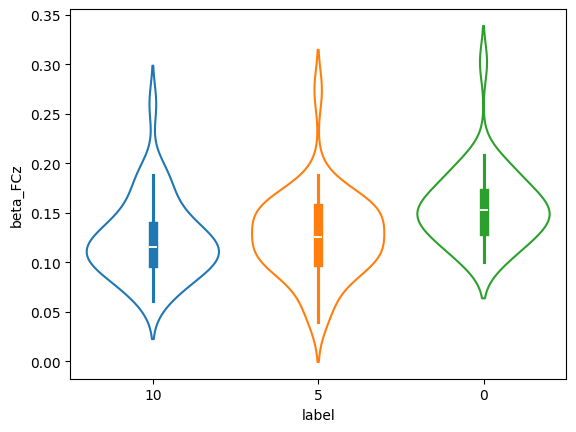

Column: mu_C1, p-value: 0.0002080336222433407


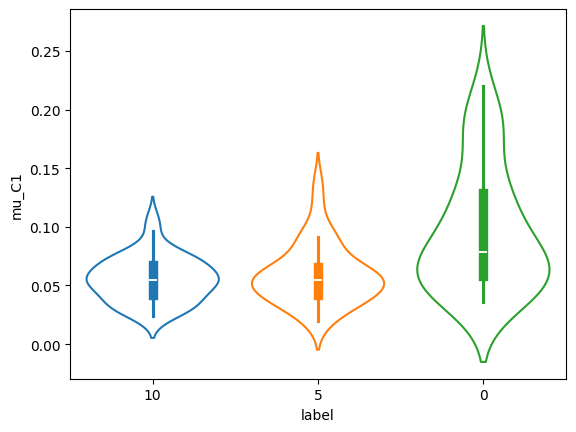

Column: mu_CP3, p-value: 0.000242611448943514


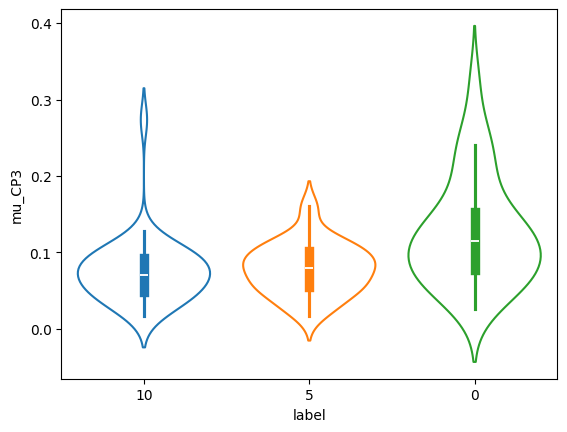

Column: mu_CP4, p-value: 0.0006124082065145199


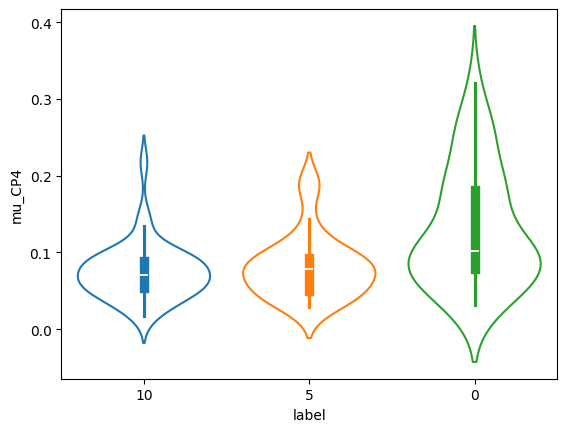

Column: mu_FC4, p-value: 0.004695934067600009


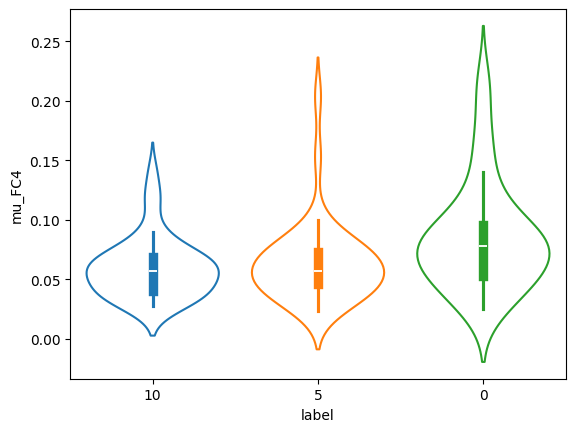

Column: mu_Oz, p-value: 0.007633333410220683


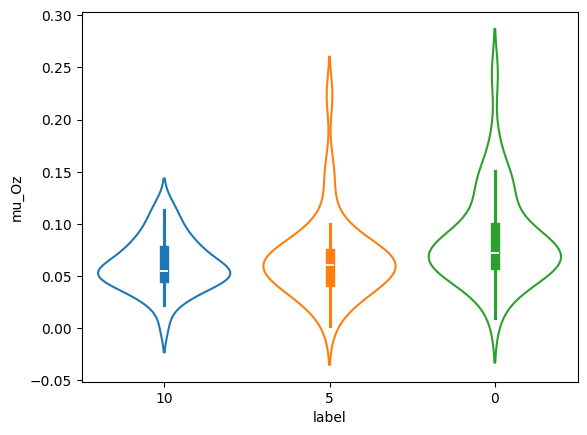

Column: mu_P3, p-value: 0.004164246426964214


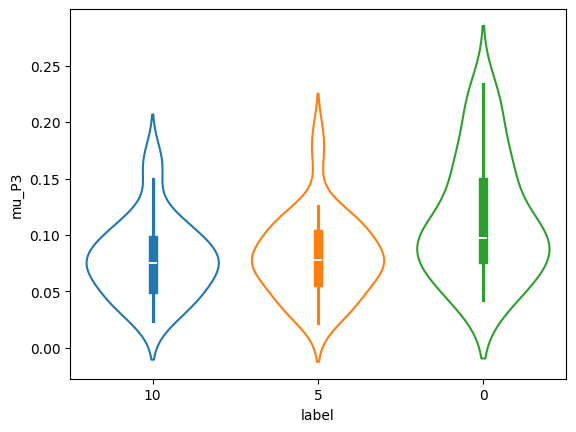

Column: mu_P4, p-value: 0.0011206421495127837


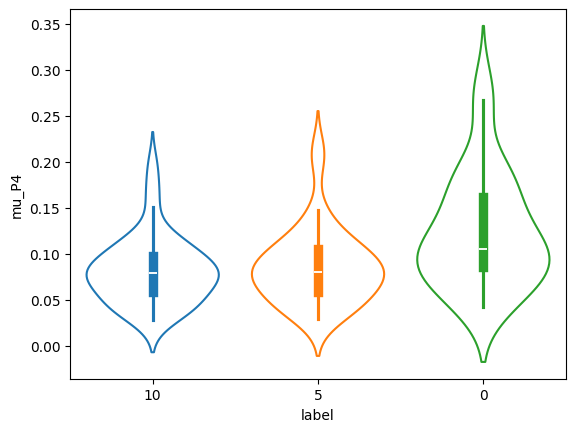

Column: beta_C4, p-value: 0.001123869483836344


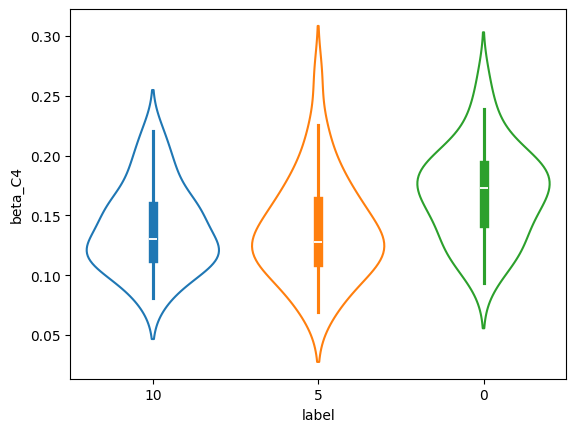

Column: beta_CP3, p-value: 0.001441909342948151


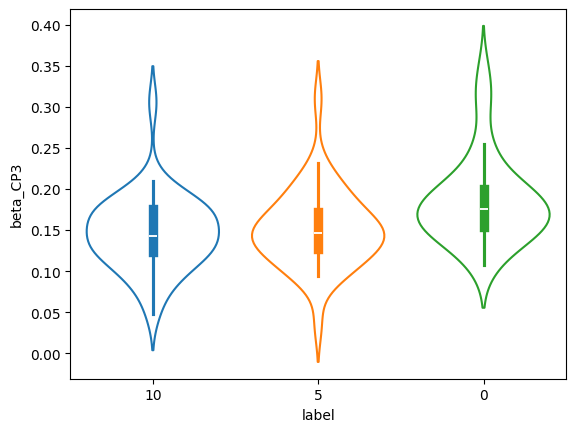

Column: beta_CP4, p-value: 0.0003996603748067463


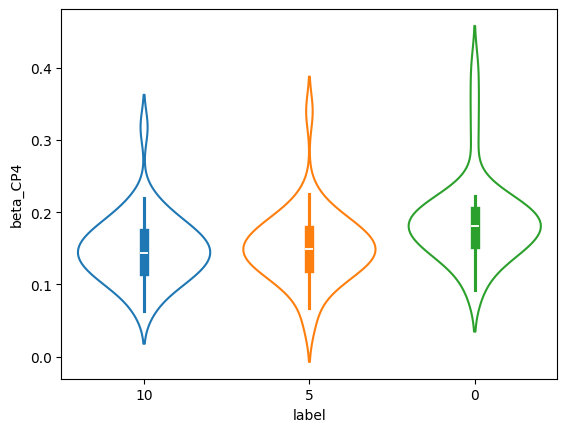

Column: beta_Cz, p-value: 0.007197182884870246


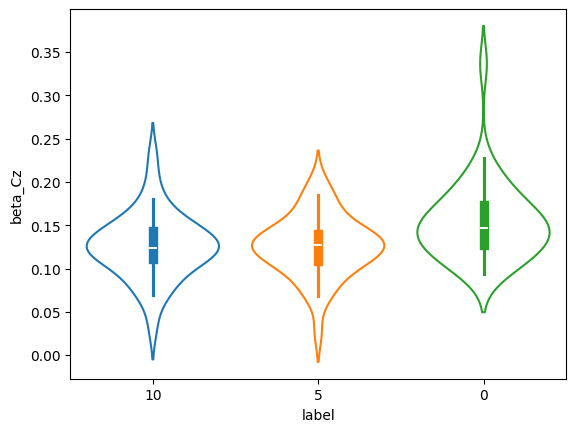

Column: beta_P4, p-value: 0.0024310049640776936


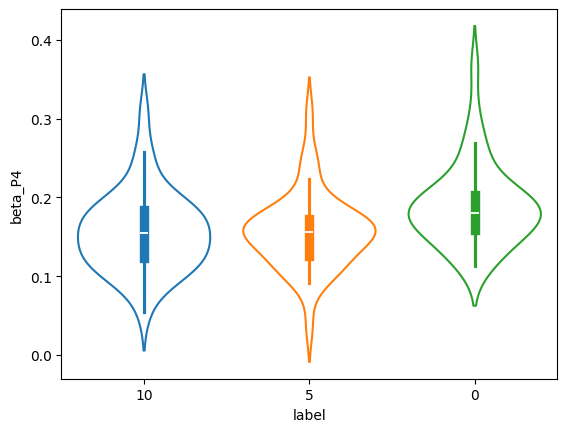

Column: mu_C3, p-value: 0.007969078891807223


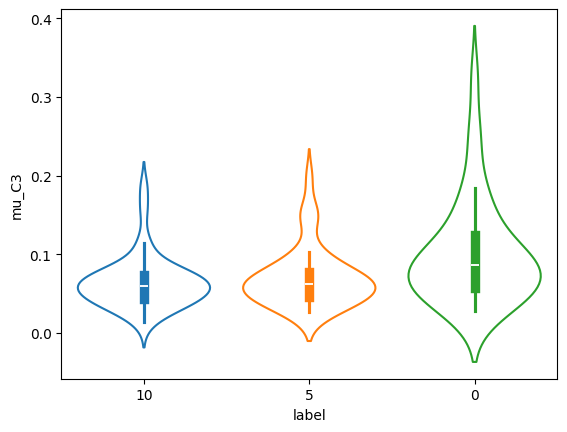

Column: mu_C4, p-value: 0.0004247157565460218


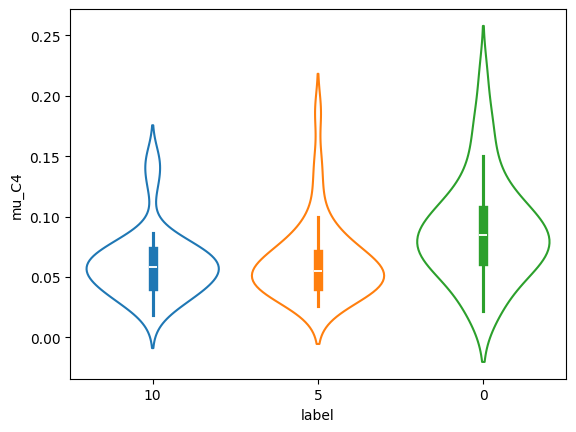

Column: mu_Cz, p-value: 0.0011872011619725063


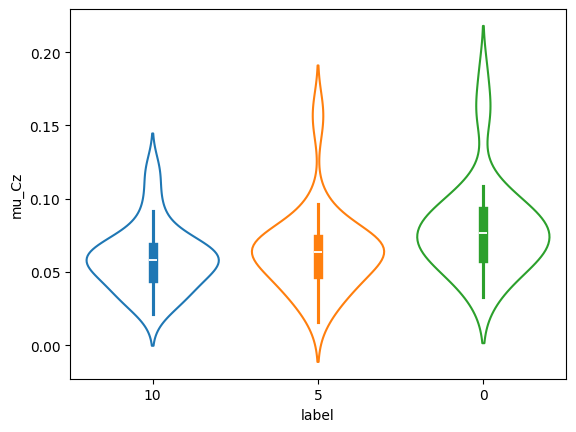

In [48]:
significant_columns = []
for column in df_means.columns:
    if column != 'label':
        test, p_val = compute_kruskal_wallis_anova(df_means, "label",  column)
        if p_val < 0.01:
            print(f"Column: {column}, p-value: {p_val}")
            sns.violinplot(x='label', y=column, data=df_means, hue='label', fill=False, log_scale=False)
            plt.show()
            significant_columns.append(column)

<Axes: >

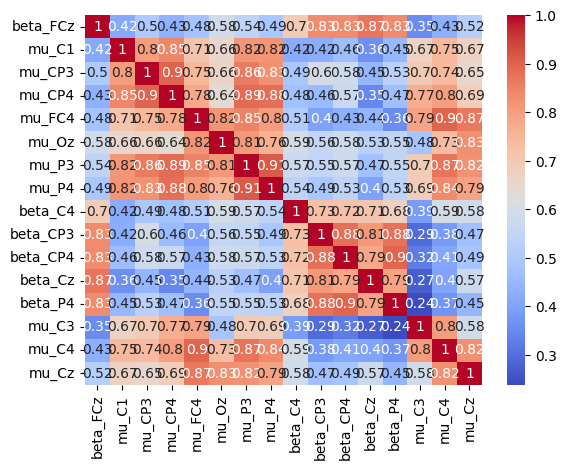

In [49]:
corr_mat = df_means[significant_columns].corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')


In [50]:
df_means["mu_C1"].values

array([0.04431551, 0.04553997, 0.05789174, 0.02975249, 0.04160315,
       0.04666318, 0.03391313, 0.03805772, 0.06098271, 0.0352674 ,
       0.03934299, 0.17898101, 0.04687349, 0.04972875, 0.09776751,
       0.05566287, 0.05959514, 0.06640088, 0.0772708 , 0.07936781,
       0.14471793, 0.08068155, 0.0605686 , 0.11851184, 0.10708723,
       0.13833499, 0.12873926, 0.09677609, 0.12018512, 0.18144717,
       0.06135876, 0.04422253, 0.12906606, 0.05956363, 0.0593055 ,
       0.19037651, 0.05551336, 0.05330124, 0.14253325, 0.02576213,
       0.02004061, 0.03578515, 0.03036555, 0.03013344, 0.04054015,
       0.03142984, 0.02951436, 0.03943025, 0.04237571, 0.090518  ,
       0.19942092, 0.05662358, 0.08597405, 0.18522417, 0.07379713,
       0.03918873, 0.04218619, 0.06781439, 0.05293445, 0.08102752,
       0.06754808, 0.06575573, 0.06055927, 0.04173048, 0.04848024,
       0.04420176, 0.03048735, 0.02061327, 0.04114526, 0.07613753,
       0.0613902 , 0.07310782, 0.07048244, 0.0916792 , 0.08949

In [65]:
abs_corr_matrix = corr_mat.abs()
corr_sum = abs_corr_matrix.sum()
least_correlated_columns = corr_sum.nsmallest(10).index
leastcorrdf_2 = (df_means[least_correlated_columns].copy())

In [66]:
leastcorrdf_2["label"] = df_means["label"].values

In [67]:
leastcorrdf_2

,mu_C3,beta_Cz,beta_P4,beta_C4,beta_CP3,beta_FCz,beta_CP4,mu_C1,mu_Oz,mu_Cz,label
0,0.051696,0.136559,0.171896,0.133217,0.152319,0.129186,0.144006,0.044316,0.049139,0.051290,10
1,0.056446,0.154346,0.164169,0.161974,0.163581,0.137556,0.145846,0.045540,0.055343,0.060078,5
2,0.068093,0.182906,0.178403,0.180497,0.167832,0.167501,0.169135,0.057892,0.073769,0.059778,0
3,0.032013,0.131958,0.116374,0.111621,0.134564,0.118527,0.126908,0.029752,0.053994,0.050840,10
4,0.044962,0.109035,0.113243,0.099827,0.126645,0.111522,0.115162,0.041603,0.047109,0.042271,5
...,...,...,...,...,...,...,...,...,...,...,...
109,0.094478,0.026160,0.037177,0.068955,0.035309,0.039878,0.040817,0.045307,0.002306,0.016288,5
110,0.234085,0.093246,0.132102,0.093493,0.145027,0.141891,0.092111,0.094866,0.010090,0.066041,0
111,0.068804,0.136105,0.166683,0.147777,0.157057,0.138245,0.164859,0.069429,0.057154,0.063725,10
112,0.073603,0.165221,0.185444,0.152222,0.164744,0.145736,0.168066,0.101715,0.060266,0.090264,5


In [68]:
leastcorrdf_2.head()
leastcorrdf_2.dropna(inplace=True)

In [69]:
sns.set_theme(style="dark")

beta_FCz
beta_Cz
beta_C4
mu_C1
mu_Cz
mu_C3


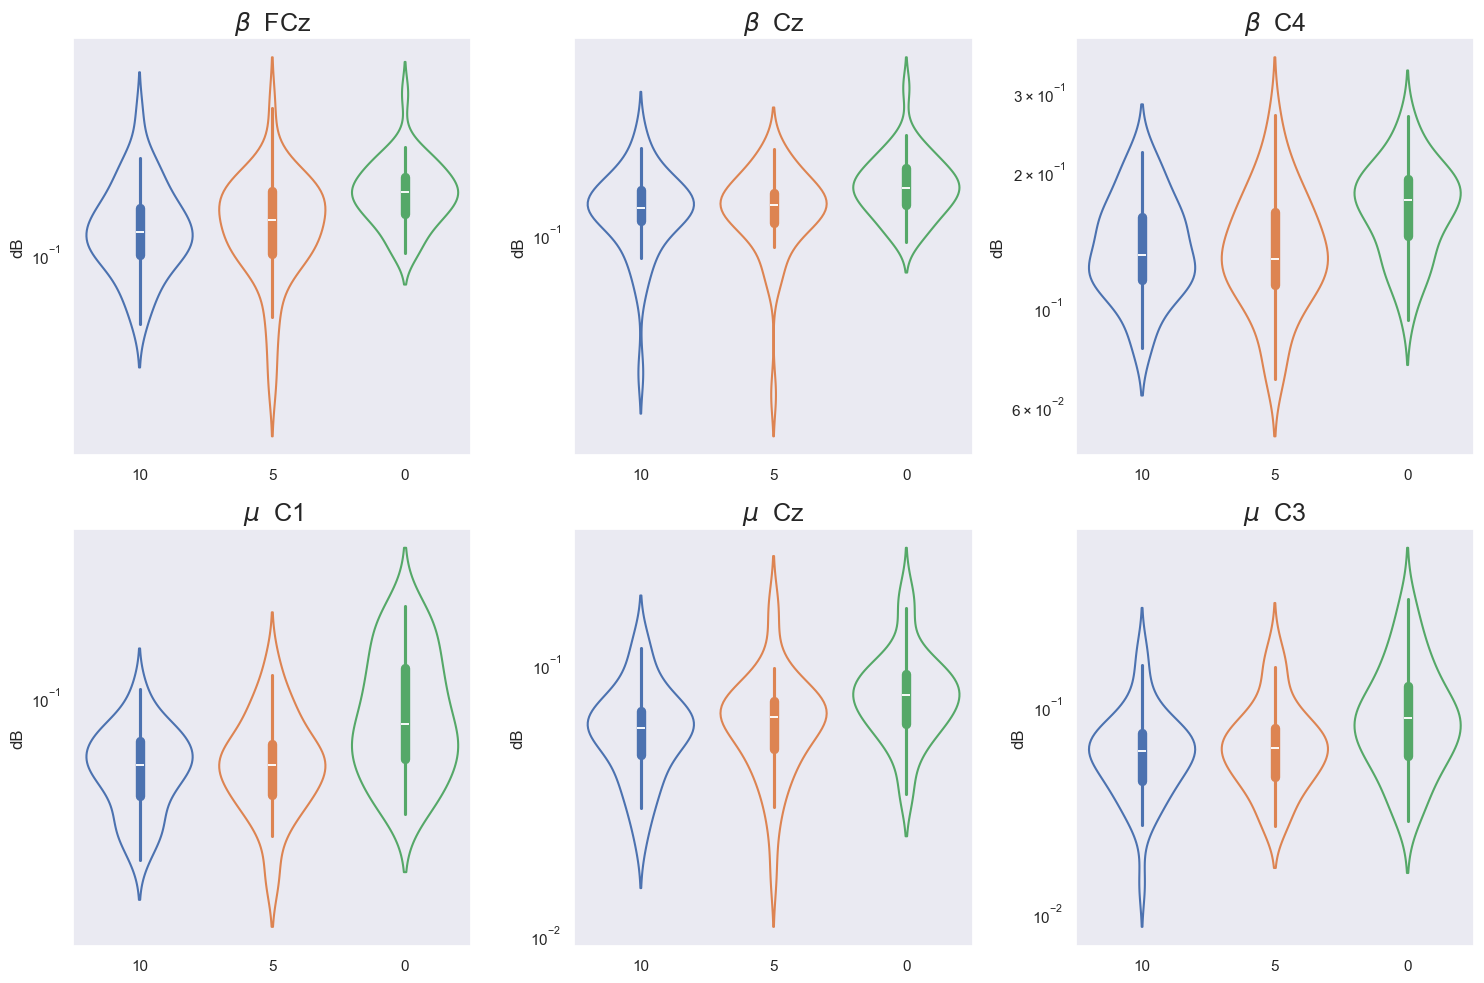

In [80]:
import math

def plot_violin_plots(dataframe):
    # Asumiendo que "label" está en las columnas de leastcorrdf_2
    columns_to_plot = dataframe.drop(columns = "label").columns
    
    num_plots = len(columns_to_plot)
    num_cols = math.ceil(math.sqrt(num_plots))  # Número de columnas en la cuadrícula
    num_rows = math.ceil(num_plots / num_cols)  # Número de filas en la cuadrícula

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

    # Aplanar el array de ejes si es necesario
    if num_plots > 1:
        axes = axes.flatten()

    # Graficamos un violin plot por cada columna
    for i, col in enumerate(columns_to_plot):
        print(col)
        sns.violinplot(x='label', y=col, data=dataframe, ax=axes[i], hue='label', fill=False, log_scale= True, legend=False, order=['10', '5', '0'])
        
        axes[i].set_title(rf'$\{col.split("_")[0]}$  {col.split("_")[1]}', fontsize=18)
        axes[i].set_xlabel('')  
        axes[i].set_ylabel('dB') 
    # Eliminar ejes vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

#plot_violin_plots(leastcorrdf_2)
# Llama a la función con tu DataFrame leastcorrdf_2
plot_violin_plots(leastcorrdf_2[["beta_FCz",  "beta_Cz", "beta_C4", "mu_C1", "mu_Cz", "mu_C3", "label"]])